#  Poverty versus services in Santiago's communes

Santiago of Chile

In [43]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://upload.wikimedia.org/wikipedia/commons/f/f4/J28_293_%C2%BBSanhattan%C2%AB.jpg")

By Osvaldo Gac Pabst  
Data Scientist

## Table of contents
* [Introduction](#introduction)
* [Business Problem](#business)
* [Data](#data)
* [Methodology](#methodology)
* [Data Preparation](#preparation)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction <a name="introduction"></a>

Santiago de Chile, is the capital and largest city of Chile as well as one of the largest cities in the Americas. It is the center of Chile's largest and most densely populated conurbation, the Santiago Metropolitan Region, whose total population is 7 million. The city is entirely located in the country's central valley. Most of the city lies between 500 m (1,640 ft) and 650 m (2,133 ft) above mean sea level.  
  
Santiago is the cultural, political and financial center of Chile and is home to the regional headquarters of many multinational corporations. The Chilean executive and judiciary are located in Santiago, but Congress meets mostly in nearby Valparaíso.  
  
The whole of Greater Santiago does not fit perfectly into any administrative division, as it extends into four different provinces and 37 **communes**. The majority of its 641.4 km2 (247.65 sq mi) (as of 2002) lie within Santiago Province, with some peripheral areas contained in the provinces of Cordillera, Maipo, and Talagante.  
  
Chile is into the 10 countries most inequality in the world, reflected in Gini’s index 0.47 in 2018, in  Santiago you can find **poor communes** and **rich communes**, nowadays difficult to understand in term of what kind of services and shops there are in each commune.  

## Business Problem <a name="business"></a>

The objective of the project is to explore the possibility of, taking advantage of state of the art Machine Learning Algorithms, to segment the communes using Foursquare API to get all the venues and services and compare with the poverty index of each commune, to resolve the questions:  
  
**“A more poor the commune less services?”**  
  
**“What type of services characterizes the poor communes and the rich communes”**

This will help to stakeholder to decide the services they want to develop in a commune considering the lack of services per commune and the level of richness

## Data <a name="data"></a>

To consider the problem we can list the datas as below:
-	I found the index of poverty of each commune to 2015[1]
-	I used Forsquare API to get the most common venues of given communes of Santiago[2] .
-	There are not too many maps of Santiago in geopandas or shapefile map, but not in gejson, so I built a map in geojson using the information of the bounder point in Carto Maps[3].

## Methodology <a name="methodology"></a>

The methodology uses in the project is:
Data Collection: Principally is a secondary source get from searching on Internet and using Foursquare API
-	Search for poverty index by communes and map it to observe the different zones in Santiago. To get the data I scraping the Wikipedia page where I found a table with the information
-	I used python folium library to visualize geographic details of Santiago and how looks each communes with different index: poverty, number of services, etc.
-	Using Foursquare get the venues per communes
-	To get the segmentation is used k-means algorithm, the reason to use this algorithm is because segmentation is the practice of partitioning a communes base into groups that have similar characteristics.
- To determine the better number of segments is used: Elbow Point, Silhouette score or Davies Bouldin score and give us the possibility to compare all of this methods
-	Analizes each group or segment and the relation with the poverty index for each commune

## Data Preparation <a name="preparation"></a>

First we need to load the libraries

In [76]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests

# Libraries to plot
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as colors

# Algorithm libraries
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score,v_measure_score
from sklearn.mixture import GaussianMixture

# Maps libraries
import folium # map rendering library
from folium.plugins import MarkerCluster

# Library to scraping a web page
from bs4 import BeautifulSoup

print('Libraries imported.')

Libraries imported.


From Wikipedia I get the information of the poverty index of each communes in Santiago

In [40]:
source = requests.get('https://es.wikipedia.org/wiki/Anexo:Comunas_de_Santiago_de_Chile').text
soup=BeautifulSoup(source,'lxml')
print(soup.title)
from IPython.display import display_html
table_comunas = soup.find_all('table')[3]

tab_comunas = str(table_comunas)

<title>Anexo:Comunas de Santiago de Chile - Wikipedia, la enciclopedia libre</title>


I convert the html into a dataframe and explore the data.

In [8]:
dfs = pd.read_html(tab_comunas)
comunas_df=dfs[0]
print(comunas_df.dtypes)
print(comunas_df.shape)
comunas_df.head()

Comuna                                   object
Ubicación?                               object
Población (2017)?                         int64
Viviendas (2002)?                         int64
Densidad poblacional (2002) ?           float64
Crecimiento demográfico (2002-2017)?     object
ICVU (2019)?                             object
Pobreza (2015)?                         float64
dtype: object
(35, 8)


Comuna   Ubicación?  Población (2017)?  Viviendas (2002)?  \
0         Cerrillos  surponiente              80832              19811   
1       Cerro Navia  norponiente             132622              35277   
2          Conchalí        norte             126955              32609   
3         El Bosque          sur             162505              42808   
4  Estación Central  surponiente             147041              32357   

   Densidad poblacional (2002) ? Crecimiento demográfico (2002-2017)?  \
0                        4329.08                                12.9%   
1                       13482.91                               -10.7%   
2                       12070.29                                -4.4%   
3                       12270.72                                -7.3%   
4                        9036.31                                16.6%   

  ICVU (2019)?  Pobreza (2015)?  
0   47.82 (74)             19.7  
1   42.42 (92)             35.6  
2   46.52 (84)             21.6  
3   48.54 (70)             27.0  
4   49.96 (64)             14.5

As we can see, there is 38 communes in the table and the poverty index.
ICVU is a synthetic index to measure the life quality in the zone related to other zones. I will save it in other dataframe.

In [9]:
ICVU_df = comunas_df[['Comuna', 'ICVU (2019)?']]   #Define a dataframe to keep ICVU
ICVU_df.head()

Comuna ICVU (2019)?
0         Cerrillos   47.82 (74)
1       Cerro Navia   42.42 (92)
2          Conchalí   46.52 (84)
3         El Bosque   48.54 (70)
4  Estación Central   49.96 (64)

I will change the names of the columns to make easy to understand the meaning

In [10]:
comunas_df = comunas_df.rename(columns={'Ubicación?': 'Location', 'Población (2017)?': 'Population_(2017)', 
                                        'Densidad poblacional (2002) ?': 'Population_density_(2002)', 
                                        'Crecimiento demográfico (2002-2017)?' : 'Population_growth_(2002-2017)', 
                                        'Pobreza (2015)?': 'Poverty_(2015)'})
comunas_df.drop(['Viviendas (2002)?', 'ICVU (2019)?'], axis=1, inplace=True)
print(comunas_df.isnull().sum())
comunas_df.head()

Comuna                           0
Location                         0
Population_(2017)                0
Population_density_(2002)        0
Population_growth_(2002-2017)    0
Poverty_(2015)                   0
dtype: int64


Comuna     Location  Population_(2017)  \
0         Cerrillos  surponiente              80832   
1       Cerro Navia  norponiente             132622   
2          Conchalí        norte             126955   
3         El Bosque          sur             162505   
4  Estación Central  surponiente             147041   

   Population_density_(2002) Population_growth_(2002-2017)  Poverty_(2015)  
0                    4329.08                         12.9%            19.7  
1                   13482.91                        -10.7%            35.6  
2                   12070.29                         -4.4%            21.6  
3                   12270.72                         -7.3%            27.0  
4                    9036.31                         16.6%            14.5

As we can see the type of the values are incorrect for the column: Population_growth_(2002-2017) , so I will create a new one and change the format to float. 

In [11]:
comunas_df['Population_growth_(2002-2017)_%'] = comunas_df['Population_growth_(2002-2017)'].map(lambda x: str(x)[:-1])
comunas_df['Population_growth_(2002-2017)_%'] = comunas_df['Population_growth_(2002-2017)_%'].str.replace(',', '.').astype(float)
print(comunas_df.dtypes)

Comuna                              object
Location                            object
Population_(2017)                    int64
Population_density_(2002)          float64
Population_growth_(2002-2017)       object
Poverty_(2015)                     float64
Population_growth_(2002-2017)_%    float64
dtype: object


Now I want to know the Santiago's total population in the analysis

In [12]:
comunas_group = comunas_df['Population_(2017)'].sum()
comunas_group

6179183

6.179.183 correspond to 88% of the population in Santiago, that is a good percentage in the analysis.  
  
Now I will get the geographical location of each commune and add to dataframe.

In [13]:
# define the dataframe columns
Comuna_loc_column = ['Comuna', 'Latitude', 'Longitude'] 

# instantiate the dataframe
Comuna_loc = pd.DataFrame(columns=Comuna_loc_column)
print(Comuna_loc)
for Comuna in comunas_df.Comuna:
    address = Comuna + ', Santiago, Chile'
    address1 = '{}'.format(address)
    print(address1)
    geolocator = Nominatim(user_agent="ny_explorer")
    location = None
    while(location is None):
        location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    print('The geograpical coordinate of ' + Comuna + ' are {}, {}.'.format(latitude, longitude))
    Comuna_loc = Comuna_loc.append({'Comuna': Comuna, 
                                'Latitude': latitude, 
                                'Longitude': longitude}, ignore_index=True)
comunas_df = pd.merge(comunas_df, Comuna_loc, left_on = 'Comuna', right_on = 'Comuna', how = 'left')
comunas_df.head()

Empty DataFrame
Columns: [Comuna, Latitude, Longitude]
Index: []
Cerrillos, Santiago, Chile
The geograpical coordinate of Cerrillos are -33.5025026, -70.7159182841177.
Cerro Navia, Santiago, Chile
The geograpical coordinate of Cerro Navia are -33.42514465, -70.7439542419355.
Conchalí, Santiago, Chile
The geograpical coordinate of Conchalí are -33.38509635, -70.6744909389865.
El Bosque, Santiago, Chile
The geograpical coordinate of El Bosque are -33.56235185, -70.6768195592874.
Estación Central, Santiago, Chile
The geograpical coordinate of Estación Central are -33.46365825, -70.7049661863186.
Huechuraba, Santiago, Chile
The geograpical coordinate of Huechuraba are -33.36551005, -70.6432115333547.
Independencia, Santiago, Chile
The geograpical coordinate of Independencia are -33.415338, -70.6658941717999.
La Cisterna, Santiago, Chile
The geograpical coordinate of La Cisterna are -33.5295218, -70.6642528940543.
La Florida, Santiago, Chile
The geograpical coordinate of La Florida are -33.

Comuna     Location  Population_(2017)  \
0         Cerrillos  surponiente              80832   
1       Cerro Navia  norponiente             132622   
2          Conchalí        norte             126955   
3         El Bosque          sur             162505   
4  Estación Central  surponiente             147041   

   Population_density_(2002) Population_growth_(2002-2017)  Poverty_(2015)  \
0                    4329.08                         12.9%            19.7   
1                   13482.91                        -10.7%            35.6   
2                   12070.29                         -4.4%            21.6   
3                   12270.72                         -7.3%            27.0   
4                    9036.31                         16.6%            14.5   

   Population_growth_(2002-2017)_%   Latitude  Longitude  
0                             12.9 -33.502503 -70.715918  
1                            -10.7 -33.425145 -70.743954  
2                             -4.4 -33.385096 -70.674491  
3                             -7.3 -33.562352 -70.676820  
4                             16.6 -33.463658 -70.704966

I will eliminate all the latin characters, because the geojson load this characters in a different way, so I will not be able to make the choropleth map

In [14]:
comunas_df = comunas_df[comunas_df['Comuna'] != 'Peñaflor']
comunas_df = comunas_df.rename(columns={'Comuna': 'comuna'})
comunas_df = comunas_df.rename(columns={'Poverty_(2015)': 'Poverty'})
comunas_df['comuna'] = comunas_df['comuna'].str.replace('í', 'i')
comunas_df['comuna'] = comunas_df['comuna'].str.replace('ó', 'o')
comunas_df['comuna'] = comunas_df['comuna'].str.replace('ñ', 'n')
comunas_df['comuna'] = comunas_df['comuna'].str.replace('é', 'e')
comunas_df['comuna'] = comunas_df['comuna'].str.replace('Ñ', 'N')
comunas_df['comuna'] = comunas_df['comuna'].str.replace('ú', 'u')
comunas_df['comuna'] = comunas_df['comuna'].astype(str)
comunas_df.loc[comunas_df['comuna'] == 'Padre Hurtado', 'Latitude'] = -33.5732584
comunas_df.loc[comunas_df['comuna'] == 'Padre Hurtado', 'Longitude'] = -70.8365311
comunas_df.loc[comunas_df['comuna'] == 'Lo Barnechea', 'Latitude'] = -33.35312
comunas_df.loc[comunas_df['comuna'] == 'Lo Barnechea', 'Longitude'] = -70.5150979
comunas_df.to_csv (r'E:/Study/Data Analytics/IBM Certification/Capstone Project/comunas_df.csv', index = None, header=True)
comunas_df.head()

comuna     Location  Population_(2017)  \
0         Cerrillos  surponiente              80832   
1       Cerro Navia  norponiente             132622   
2          Conchali        norte             126955   
3         El Bosque          sur             162505   
4  Estacion Central  surponiente             147041   

   Population_density_(2002) Population_growth_(2002-2017)  Poverty  \
0                    4329.08                         12.9%     19.7   
1                   13482.91                        -10.7%     35.6   
2                   12070.29                         -4.4%     21.6   
3                   12270.72                         -7.3%     27.0   
4                    9036.31                         16.6%     14.5   

   Population_growth_(2002-2017)_%   Latitude  Longitude  
0                             12.9 -33.502503 -70.715918  
1                            -10.7 -33.425145 -70.743954  
2                             -4.4 -33.385096 -70.674491  
3                             -7.3 -33.562352 -70.676820  
4                             16.6 -33.463658 -70.704966

Using a bar plot, I observe which communes are the poorest and the richest.

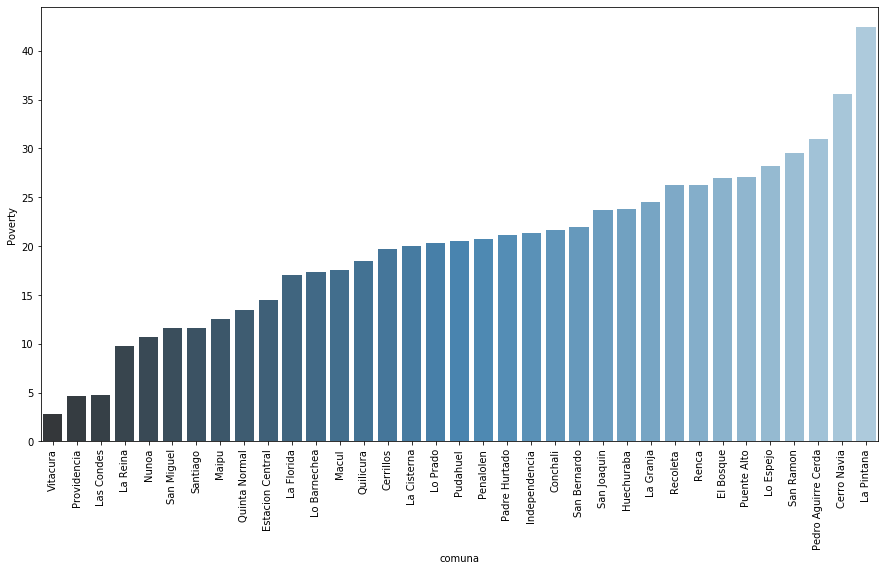

In [15]:
comunas_df.sort_values(by = ['Poverty'], inplace = True)
plt.figure(figsize=(15,8))
sns.barplot(x='comuna', y='Poverty', data=comunas_df, palette="Blues_d", capsize= 2.0)
plt.xticks(rotation=90);

We can observe the poorest communes: La Pintana and Cerro Navia. Let's do a map to see where are located this zones. 
First I create a an array to develop a a way to give a color to each poverty level.

In [16]:
# create a numpy array of length 10 and has linear spacing from the minium Proverty index to the maximum Proverty index

scale = np.linspace(comunas_df['Poverty'].min(), 
                    comunas_df['Poverty'].max(), 
                    10, dtype=int)
scale = scale.tolist() # change the numpy array to a list
scale[-1] = scale[-1] + 1 # make sure that the last value of the list is greater than the maximum of Poverty index

Let's see how is Santiago of Chile

In [78]:
# Getting the locations of the Santiango
address = 'Santiago, Santiago, Chile'
geolocator = Nominatim(user_agent="ny_explorer")
location = None
while(location is None):
    location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print('The geograpical coordinate of ' + 'Santiago' + ' are {}, {}.'.format(latitude, longitude))

map_Santiago = folium.Map(location=[latitude, longitude], zoom_start=11)
map_Santiago.save('map_Santiago.html')
map_Santiago

The geograpical coordinate of Santiago are -33.4377968, -70.6504451.


Now I load the geojson that include all the bounderies of each communes and get the latitud and longitud of Santiago.

In [41]:
# The path of the geojson file with the comuna zone
stgo_path = 'E:/Data Analytics/Data Base/Chile Maps/Comunas/Comunas_Santiago1.geojson'
print(stgo_path)

# Loading the json
with open(stgo_path, 'r') as output:
    Santiago_geojson = json.load(output)

E:/Data Analytics/Data Base/Chile Maps/Comunas/Comunas_Santiago1.geojson


Let's map the poverty index in a choropleth map

In [147]:
# let Folium determine the scale.
map_Santiago.choropleth(
    geo_data=Santiago_geojson,
    name = 'Santiago Poverty',
    data = comunas_df,
    columns=['comuna', 'Poverty'],
    key_on='feature.properties.comuna',
    threshold_scale = scale,
    fill_color= 'YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Poverty 2015 by Comuna in Santiago Chile',
    reset=True
)

comunas_mark = folium.map.FeatureGroup()


for lat, lng, in zip(comunas_df.Latitude, comunas_df.Longitude):
    comunas_mark.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

latitudes = list(comunas_df.Latitude)
longitudes = list(comunas_df.Longitude)
labels = list(comunas_df.comuna)

for lat, lng, label in zip(latitudes, longitudes, labels):
    folium.Marker([lat, lng], popup=label).add_to(map_Santiago)  

map_Santiago.add_child(comunas_mark)
map_Santiago.save('map_SantiagoChoro.html')
map_Santiago

C:\anaconda3\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


The poorest zones are located to the southwest and northwest of the Santiago, and the richest zone are located to the east of Santiago.

Using the Foursquare API, I will get all the venues in each communes

In [20]:
CLIENT_ID = 'EHXMGRMV3RFFRADERZQ1MPEKD2CIUTOSCKKTEY1DU0CULNMQ' # your Foursquare ID
CLIENT_SECRET = 'W0LZBJ0UZTWB3H2DBFXBIH3VXE4X32P2PQ3PHFIYX0SKNX0Z' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: EHXMGRMV3RFFRADERZQ1MPEKD2CIUTOSCKKTEY1DU0CULNMQ
CLIENT_SECRET:W0LZBJ0UZTWB3H2DBFXBIH3VXE4X32P2PQ3PHFIYX0SKNX0Z


In [120]:
LIMIT = 100
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['comuna', 
                  'comuna_Latitude', 
                  'comuna_Longitude', 
                  'Venue', 
                  'Venue_Latitude', 
                  'Venue_Longitude', 
                  'Venue_Category']
    
    return(nearby_venues)

In [121]:
Santiago_venues = getNearbyVenues(names=comunas_df['comuna'],
                                   latitudes=comunas_df['Latitude'],
                                   longitudes=comunas_df['Longitude']
                                  )

Vitacura
Providencia
Las Condes
La Reina
Nunoa
San Miguel
Santiago
Maipu
Quinta Normal
Estacion Central
La Florida
Lo Barnechea
Macul
Quilicura
Cerrillos
La Cisterna
Lo Prado
Pudahuel
Penalolen
Padre Hurtado
Independencia
Conchali
San Bernardo
San Joaquin
Huechuraba
La Granja
Recoleta
Renca
El Bosque
Puente Alto
Lo Espejo
San Ramon
Pedro Aguirre Cerda
Cerro Navia
La Pintana


In [122]:
print(Santiago_venues.shape)
Santiago_venues.head()

(1788, 7)


comuna  comuna_Latitude  comuna_Longitude  \
0  Vitacura        -33.38015        -70.565785   
1  Vitacura        -33.38015        -70.565785   
2  Vitacura        -33.38015        -70.565785   
3  Vitacura        -33.38015        -70.565785   
4  Vitacura        -33.38015        -70.565785   

                                Venue  Venue_Latitude  Venue_Longitude  \
0          Club de Golf Sport Francés      -33.380146       -70.562518   
1                      Spa One & Only      -33.382544       -70.572007   
2                      La Chocolatine      -33.386412       -70.563223   
3                     La Guapa Simona      -33.382437       -70.571933   
4  Pasteleria y Heladeria - La Ermita      -33.383683       -70.573423   

       Venue_Category  
0         Golf Course  
1                 Spa  
2              Bakery  
3  Salon / Barbershop  
4      Ice Cream Shop

As we can see Foursquare return 1788 venues for all communes and now I will included in a Map to see the venues

In [123]:
map_Santiago = folium.Map(location=[latitude, longitude], zoom_start=11)
comunas_venues = folium.map.FeatureGroup()

for lat, lng, in zip(Santiago_venues.Venue_Latitude, Santiago_venues.Venue_Longitude):
    comunas_mark.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=3, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

latitudes = list(Santiago_venues.Venue_Latitude)
longitudes = list(Santiago_venues.Venue_Longitude)
labels = list(Santiago_venues.Venue_Category)

for lat, lng, label in zip(latitudes, longitudes, labels):
    folium.Marker([lat, lng], popup=label).add_to(map_Santiago)   
    
# add incidents to map
map_Santiago.add_child(comunas_venues)
map_Santiago.save('map_SantiagoMarkVenues.html')
map_Santiago

There are too many, so I will analyse using a cluster marker to reduce the marks depending of the zoom

In [124]:
# create empty map zoomed in on Santiago
map_Santiago = folium.Map(location=[latitude, longitude], zoom_start=11)


Santiago_cluster = MarkerCluster() #creating a Marker for each point in Santiago_venues. Each point will get a popup with their location

for row in Santiago_venues.itertuples():
    Santiago_cluster.add_child(folium.Marker(location=[row.Venue_Latitude,  row.Venue_Longitude],
                 popup=row.Venue))
 
map_Santiago.add_child(Santiago_cluster)
map_Santiago.save('map_SantiagoclusterVenues.html')  
map_Santiago

## Analysis <a name="analysis"></a>

Now it is easier to see the venues in each commune.
let's plot and examine the venues in each commune.

In [171]:
Santiago_venues.groupby('comuna').count()
Santiago_venues_count = Santiago_venues.groupby('comuna').count().reset_index()
Santiago_venues_count.head()

comuna  comuna_Latitude  comuna_Longitude  Venue  Venue_Latitude  \
0         Cerrillos               77                77     77              77   
1       Cerro Navia               12                12     12              12   
2          Conchali               26                26     26              26   
3         El Bosque               19                19     19              19   
4  Estacion Central               64                64     64              64   

   Venue_Longitude  Venue_Category  
0               77              77  
1               12              12  
2               26              26  
3               19              19  
4               64              64

In [172]:
Santiago_venues_count.sort_values(by = ['comuna_Latitude'], inplace = True)
Santiago_venues_count = Santiago_venues_count.rename(columns={'comuna_Latitude': 'Venues_total'})
Santiago_venues_count.drop(['comuna_Longitude', 'Venue', 'Venue_Latitude', 'Venue_Longitude', 'Venue_Category'], 
                           axis=1, inplace=True)

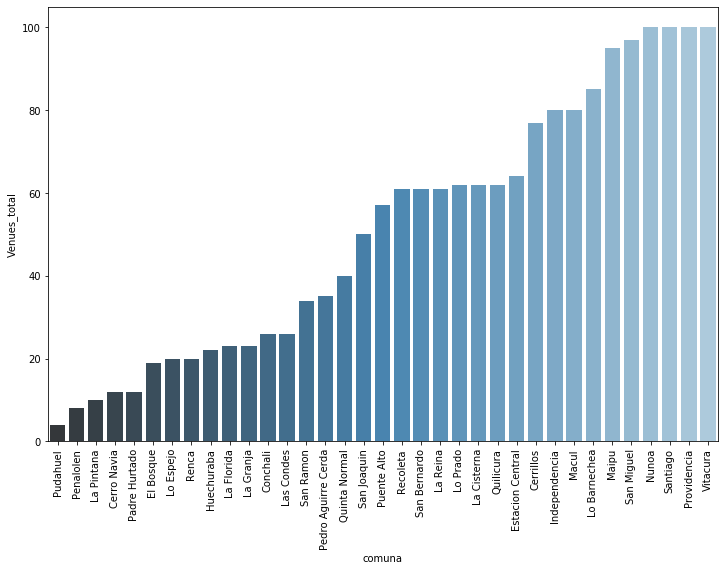

In [188]:
plt.figure(figsize=(12,8))
sns.barplot(x='comuna', y='Venues_total', data=Santiago_venues_count, palette="Blues_d", capsize= 2.0)
plt.xticks(rotation=90);

When we map we can compare with the poverty

In [174]:
Santiago_venues_count = pd.merge(Santiago_venues_count, 
                                     comunas_df, how='left', 
                                     left_on=['comuna'], right_on=['comuna'])

In [178]:
Santiago_venues_count.head()

comuna  Venues_total     Location  Population_(2017)  \
0       Pudahuel             4  norponiente             230293   
1      Penalolen             8   suroriente             241599   
2     La Pintana            10          sur             177335   
3    Cerro Navia            12  norponiente             132622   
4  Padre Hurtado            12  surponiente              63250   

   Population_density_(2002) Population_growth_(2002-2017)  Poverty  \
0                   10728.68                           18%     20.5   
1                    3970.96                         11.8%     20.7   
2                    6189.68                         -6.8%     42.4   
3                   13482.91                        -10.7%     35.6   
4                    4616.85                         64.2%     21.1   

   Population_growth_(2002-2017)_%   Latitude  Longitude  
0                             18.0 -33.419373 -70.863356  
1                             11.8 -33.486225 -70.509290  
2                             -6.8 -33.591389 -70.636396  
3                            -10.7 -33.425145 -70.743954  
4                             64.2 -33.573258 -70.836531

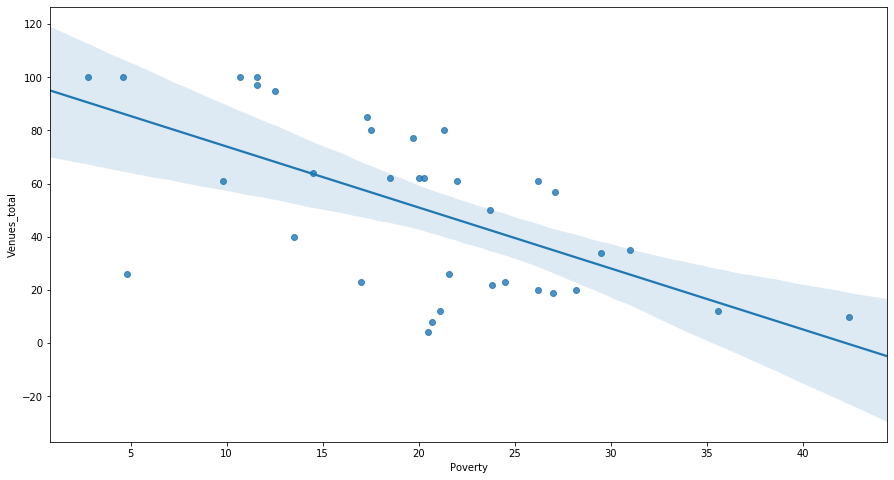

In [186]:
plt.figure(figsize=(15,8))
sns.regplot(x="Poverty", y="Venues_total", data=Santiago_venues_count)

We can see a relation between the poverty and the amount of venues in the commune

Next, let's group rows by communes and by taking the mean of the frequency of occurrence of each category

In [126]:
print('There are {} uniques categories.'.format(len(Santiago_venues['comuna'].unique())))

There are 35 uniques categories.


In [127]:
# one hot encoding
comuna_onehot = pd.get_dummies(Santiago_venues[['Venue_Category']], prefix="", prefix_sep="")

# add commune column back to dataframe
comuna_onehot['comuna'] = Santiago_venues['comuna'] 

# move commune column to the first column
fixed_columns = [comuna_onehot.columns[-1]] + list(comuna_onehot.columns[:-1])
comuna_onehot = comuna_onehot[fixed_columns]

comuna_onehot.head()

comuna  Accessories Store  Airport  American Restaurant  Antique Shop  \
0  Vitacura                  0        0                    0             0   
1  Vitacura                  0        0                    0             0   
2  Vitacura                  0        0                    0             0   
3  Vitacura                  0        0                    0             0   
4  Vitacura                  0        0                    0             0   

   Arcade  Arepa Restaurant  Argentinian Restaurant  Art Gallery  Art Museum  \
0       0                 0                       0            0           0   
1       0                 0                       0            0           0   
2       0                 0                       0            0           0   
3       0                 0                       0            0           0   
4       0                 0                       0            0           0   

   ...  Video Game Store  Volleyball Court  Water Park  Wine Bar  Wine Shop  \
0  ...                 0                 0           0         0          0   
1  ...                 0                 0           0         0          0   
2  ...                 0                 0           0         0          0   
3  ...                 0                 0           0         0          0   
4  ...                 0                 0           0         0          0   

   Winery  Wings Joint  Women's Store  Yoga Studio  Zoo Exhibit  
0       0            0              0            0            0  
1       0            0              0            0            0  
2       0            0              0            0            0  
3       0            0              0            0            0  
4       0            0              0            0            0  

[5 rows x 239 columns]

And let's examine the new dataframe size

In [128]:
comuna_onehot.shape

(1788, 239)

Next, let's group rows by commune and by taking the mean of the frequency of occurrence of each category

In [129]:
comuna_grouped = comuna_onehot.groupby('comuna').mean().reset_index()
comuna_grouped

comuna  Accessories Store   Airport  American Restaurant  \
0             Cerrillos           0.000000  0.012987             0.025974   
1           Cerro Navia           0.000000  0.000000             0.000000   
2              Conchali           0.000000  0.000000             0.000000   
3             El Bosque           0.000000  0.000000             0.000000   
4      Estacion Central           0.000000  0.000000             0.000000   
5            Huechuraba           0.000000  0.000000             0.000000   
6         Independencia           0.000000  0.000000             0.000000   
7           La Cisterna           0.000000  0.000000             0.000000   
8            La Florida           0.000000  0.000000             0.000000   
9             La Granja           0.000000  0.000000             0.000000   
10           La Pintana           0.000000  0.000000             0.000000   
11             La Reina           0.000000  0.000000             0.016393   
12           Las Condes           0.000000  0.000000             0.000000   
13         Lo Barnechea           0.011765  0.000000             0.000000   
14            Lo Espejo           0.000000  0.000000             0.000000   
15             Lo Prado           0.000000  0.000000             0.016129   
16                Macul           0.000000  0.000000             0.000000   
17                Maipu           0.000000  0.000000             0.000000   
18                Nunoa           0.000000  0.000000             0.000000   
19        Padre Hurtado           0.000000  0.000000             0.000000   
20  Pedro Aguirre Cerda           0.000000  0.000000             0.000000   
21            Penalolen           0.000000  0.000000             0.000000   
22          Providencia           0.000000  0.000000             0.000000   
23             Pudahuel           0.000000  0.000000             0.000000   
24          Puente Alto           0.000000  0.000000             0.000000   
25            Quilicura           0.000000  0.000000             0.000000   
26        Quinta Normal           0.000000  0.000000             0.000000   
27             Recoleta           0.000000  0.000000             0.016393   
28                Renca           0.000000  0.000000             0.000000   
29         San Bernardo           0.000000  0.000000             0.000000   
30          San Joaquin           0.000000  0.000000             0.000000   
31           San Miguel           0.000000  0.000000             0.000000   
32            San Ramon           0.000000  0.000000             0.000000   
33             Santiago           0.000000  0.000000             0.000000   
34             Vitacura           0.000000  0.020000             0.000000   

    Antique Shop    Arcade  Arepa Restaurant  Argentinian Restaurant  \
0         0.0000  0.012987          0.000000                0.000000   
1         0.0000  0.000000          0.000000                0.000000   
2         0.0000  0.000000          0.000000                0.000000   
3         0.0000  0.000000          0.000000                0.000000   
4         0.0000  0.000000          0.000000                0.015625   
5         0.0000  0.000000          0.000000                0.000000   
6         0.0125  0.000000          0.000000                0.000000   
7         0.0000  0.000000          0.000000                0.000000   
8         0.0000  0.000000          0.000000                0.000000   
9         0.0000  0.000000          0.000000                0.000000   
10        0.0000  0.000000          0.000000                0.000000   
11        0.0000  0.000000          0.000000                0.000000   
12        0.0000  0.000000          0.000000                0.000000   
13        0.0000  0.011765          0.000000                0.011765   
14        0.0000  0.000000          0.000000                0.000000   
15        0.0000  0.000000          0.000000                0.000000   
16        0.0000  0.

Let's print each commune along with the top 5 most common venues

In [130]:
num_top_venues = 5

for hood in comuna_grouped['comuna']:
    print("----"+hood+"----")
    temp = comuna_grouped[comuna_grouped['comuna'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Cerrillos----
                    venue  freq
0    Fast Food Restaurant  0.08
1        Department Store  0.06
2  Furniture / Home Store  0.04
3                Pharmacy  0.04
4          Ice Cream Shop  0.04


----Cerro Navia----
         venue  freq
0       Bakery  0.17
1        Plaza  0.17
2     Pharmacy  0.08
3         Park  0.08
4  Bus Station  0.08


----Conchali----
               venue  freq
0           Pharmacy  0.12
1              Plaza  0.08
2         Food Truck  0.08
3               Park  0.08
4  Convenience Store  0.04


----El Bosque----
           venue  freq
0    Supermarket  0.16
1    Flea Market  0.11
2       Pharmacy  0.11
3           Food  0.05
4  Shopping Mall  0.05


----Estacion Central----
                  venue  freq
0              Pharmacy  0.06
1           Bus Station  0.06
2                Bakery  0.06
3  Fast Food Restaurant  0.05
4           Pizza Place  0.05


----Huechuraba----
                   venue  freq
0            Bus Station  0.18
1            

First, let's write a function to sort the venues in descending order

In [131]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each commune

In [132]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['comuna']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
comunas_venues_sorted = pd.DataFrame(columns=columns)
comunas_venues_sorted['comuna'] = comuna_grouped['comuna']

for ind in np.arange(comuna_grouped.shape[0]):
    comunas_venues_sorted.iloc[ind, 1:] = return_most_common_venues(comuna_grouped.iloc[ind, :], num_top_venues)

comunas_venues_sorted.head()

comuna 1st Most Common Venue 2nd Most Common Venue  \
0         Cerrillos  Fast Food Restaurant      Department Store   
1       Cerro Navia                 Plaza                Bakery   
2          Conchali              Pharmacy            Food Truck   
3         El Bosque           Supermarket              Pharmacy   
4  Estacion Central                Bakery           Bus Station   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0              Pharmacy        Ice Cream Shop             BBQ Joint   
1           Bus Station                  Park              Pharmacy   
2                  Park                 Plaza                Winery   
3           Flea Market                  Pool    Chinese Restaurant   
4              Pharmacy           Pizza Place  Fast Food Restaurant   

    6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0  Furniture / Home Store        Sandwich Place        Clothing Store   
1           Big Box Store           Flea Market   Fried Chicken Joint   
2            Cupcake Shop        Sandwich Place               Stadium   
3        Department Store           Bus Station          Burger Joint   
4        Sushi Restaurant  Other Great Outdoors          Soccer Field   

  9th Most Common Venue 10th Most Common Venue  
0         Movie Theater       Sushi Restaurant  
1      Department Store         Farmers Market  
2           Supermarket       Sushi Restaurant  
3         Shopping Mall         Breakfast Spot  
4        Farmers Market       Asian Restaurant

**Calculate k-mean, Silhouette and Davies Bouldin scores for 2 to 12 cluesters**

In [133]:
comuna_grouped_clustering = comuna_grouped.drop('comuna', 1)

# Generate the score for each number of clusters
km_scores= []
km_silhouette = []
vmeasure_score =[]
db_score = []
for i in range(2,12):
    km = KMeans(n_clusters=i, random_state=0).fit(comuna_grouped_clustering)
    preds = km.predict(comuna_grouped_clustering)
    
    print("Score for number of cluster(s) {}: {}".format(i,km.score(comuna_grouped_clustering)))
    km_scores.append(-km.score(comuna_grouped_clustering))
    
    silhouette = silhouette_score(comuna_grouped_clustering,preds)
    km_silhouette.append(silhouette)
    print("Silhouette score for number of cluster(s) {}: {}".format(i,silhouette))
    
    db = davies_bouldin_score(comuna_grouped_clustering,preds)
    db_score.append(db)
    print("Davies Bouldin score for number of cluster(s) {}: {}".format(i,db))

Score for number of cluster(s) 2: -1.2679211638203136
Silhouette score for number of cluster(s) 2: 0.481220804084996
Davies Bouldin score for number of cluster(s) 2: 0.37092502160018653
Score for number of cluster(s) 3: -1.0651226803825224
Silhouette score for number of cluster(s) 3: 0.46195019987244085
Davies Bouldin score for number of cluster(s) 3: 0.3672003140972049
Score for number of cluster(s) 4: -0.954587341208245
Silhouette score for number of cluster(s) 4: 0.0998055621306743
Davies Bouldin score for number of cluster(s) 4: 1.566622447481152
Score for number of cluster(s) 5: -0.9123360913652732
Silhouette score for number of cluster(s) 5: 0.03105886594815986
Davies Bouldin score for number of cluster(s) 5: 1.7741911216066382
Score for number of cluster(s) 6: -0.7998063885530038
Silhouette score for number of cluster(s) 6: 0.1343172631069729
Davies Bouldin score for number of cluster(s) 6: 1.2661388714869644
Score for number of cluster(s) 7: -0.7707679668590831
Silhouette score

Plot to determine the number of cluster using Elbow point

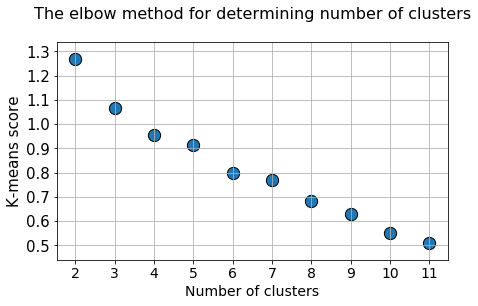

In [134]:
plt.figure(figsize=(7,4))
plt.title("The elbow method for determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(2,12)],y=km_scores,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("K-means score",fontsize=15)
plt.xticks([i for i in range(2,12)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

Plot to determine the number of cluster using Silhouette score

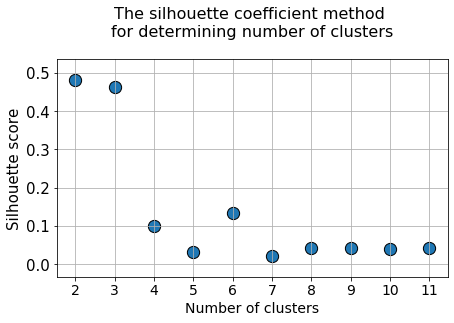

In [135]:
plt.figure(figsize=(7,4))
plt.title("The silhouette coefficient method \nfor determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(2,12)],y=km_silhouette,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("Silhouette score",fontsize=15)
plt.xticks([i for i in range(2,12)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

Plot to determine the number of cluster using Davies-Bouldin score

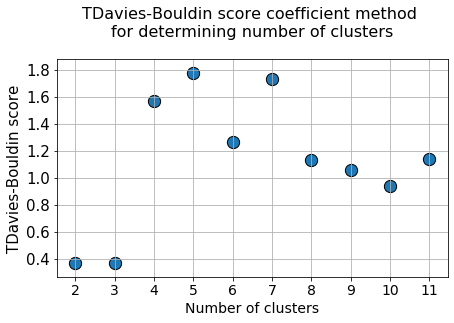

In [189]:
plt.figure(figsize=(7,4))
plt.title("TDavies-Bouldin score coefficient method \nfor determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(2,12)],y=db_score,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("TDavies-Bouldin score",fontsize=15)
plt.xticks([i for i in range(2,12)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

In [144]:
# set number of clusters
kclusters = 3

comuna_grouped_clustering = comuna_grouped.drop('comuna', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(comuna_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:36] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [145]:
# add clustering labels
comunas_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

comunas_merged = comunas_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
comunas_merged = comunas_merged.join(comunas_venues_sorted.set_index('comuna'), on='comuna')

comunas_merged # check the last columns!

comuna     Location  Population_(2017)  \
34             Vitacura   nororiente              85384   
22          Providencia   nororiente             142079   
12           Las Condes   nororiente             294838   
11             La Reina   nororiente              92787   
18                Nunoa   nororiente             208237   
31           San Miguel          sur             107954   
33             Santiago       centro             404495   
17                Maipu  surponiente             521627   
26        Quinta Normal  norponiente             110026   
4      Estacion Central  surponiente             147041   
8            La Florida   suroriente             366916   
13         Lo Barnechea   nororiente             105833   
16                Macul   suroriente             116534   
25            Quilicura        norte             210410   
0             Cerrillos  surponiente              80832   
7           La Cisterna          sur              90119   
15             Lo Prado  norponiente              96249   
23             Pudahuel  norponiente             230293   
21            Penalolen   suroriente             241599   
19        Padre Hurtado  surponiente              63250   
6         Independencia        norte             100281   
2              Conchali        norte             126955   
29         San Bernardo          sur             297262   
30          San Joaquin          sur              94492   
5            Huechuraba        norte              98671   
9             La Granja          sur             116571   
27             Recoleta        norte             157851   
28                Renca  norponiente             147151   
3             El Bosque          sur             162505   
24          Puente Alto   suroriente             568106   
14            Lo Espejo          sur              98804   
32            San Ramon          sur              82900   
20  Pedro Aguirre Cerda          sur             101174   
1           Cerro Navia  norponiente             132622   
10           La Pintana          sur             177335   

    Population_density_(2002) Population_growth_(2002-2017)  Poverty  \
34                    2846.63                          6.2%      2.8   
22                    8429.15                         21.4%      4.6   
12                    2519.84                         19.6%      4.8   
11                    4077.62                         -3.8%      9.8   
18                    9698.16                         28.2%     10.7   
31                    8122.76                         38.6%     11.6   
33                    8654.83                         88.9%     11.6   
17                    8436.93                         11.5%     12.5   
26                    8762.59                            6%     13.5   
4                     9036.31                         16.6%     14.5   
8                     9356.62                          0.6%     17.0   
13                    1318.22                         43,2%     17.3   
16                    8757.59                          4.1%     17.5   
25                    3254.11                         66.6%     18.5   
0                     4329.08                         12.9%     19.7   
7                     8477.89                            6%     20.0   
15                   15926.11                         -7.8%     20.3   
23                   10728.68                           18%     20.5   
21                    3970.96                         11.8%     20.7   
19                    4616.85                         64.2%     21.1   
6                     8824.66                         55.4%     21.3   
2                    12070.29                         -4.4%     21.6   
29                    4605.85                         20.4%     22.0   
30                    9871.08                         -2,1%     23.7   
5                     3493.87                         33.4%     23.8   
9                   

Finally, let's visualize the resulting clusters over each commune

In [148]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# let Folium determine the scale.
map_clusters.choropleth(
    geo_data=Santiago_geojson,
    name = 'Santiago Poverty',
    data = comunas_df,
    columns=['comuna', 'Poverty'],
    key_on='feature.properties.comuna',
    threshold_scale = scale,
    fill_color= 'YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Poverty 2015 by Comuna in Santiago Chile',
    reset=True
)


# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(comunas_merged['Latitude'], comunas_merged['Longitude'], comunas_merged['comuna'], comunas_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters.save('map_Santiagoclusters.html')
map_clusters

**Examine Clusters**

Cluster 1

In [149]:
comunas_merged.loc[comunas_merged['Cluster Labels'] == 0, comunas_merged.columns[[1] + list(range(5, comunas_merged.shape[1]))]]

Location  Poverty  Population_growth_(2002-2017)_%   Latitude  \
34   nororiente      2.8                              6.2 -33.380150   
22   nororiente      4.6                             21.4 -33.428838   
12   nororiente      4.8                             19.6 -33.424788   
11   nororiente      9.8                             -3.8 -33.447373   
18   nororiente     10.7                             28.2 -33.454320   
31          sur     11.6                             38.6 -33.497550   
33       centro     11.6                             88.9 -33.437797   
17  surponiente     12.5                             11.5 -33.509441   
26  norponiente     13.5                              6.0 -33.428357   
4   surponiente     14.5                             16.6 -33.463658   
8    suroriente     17.0                              0.6 -33.530714   
13   nororiente     17.3                             43.2 -33.353120   
16   suroriente     17.5                              4.1 -33.491943   
25        norte     18.5                             66.6 -33.355188   
0   surponiente     19.7                             12.9 -33.502503   
7           sur     20.0                              6.0 -33.529522   
15  norponiente     20.3                             -7.8 -33.447775   
19  surponiente     21.1                             64.2 -33.573258   
6         norte     21.3                             55.4 -33.415338   
2         norte     21.6                             -4.4 -33.385096   
29          sur     22.0                             20.4 -33.592283   
30          sur     23.7                             -2.1 -33.493640   
5         norte     23.8                             33.4 -33.365510   
9           sur     24.5                            -12.2 -33.535879   
27        norte     26.2                              7.2 -33.406199   
28  norponiente     26.2                             10.2 -33.403767   
3           sur     27.0                             -7.3 -33.562352   
24   suroriente     27.1                             15.7 -33.609528   
14          sur     28.2                            -12.6 -33.520168   
32          sur     29.5                            -12.4 -33.537816   
20          sur     31.0                            -11.6 -33.492726   
1   norponiente     35.6                            -10.7 -33.425145   
10          sur     42.4                             -6.8 -33.591389   

    Longitude  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
34 -70.565785               0                  Café      Sushi Restaurant   
22 -70.611341               0           Coffee Shop          Burger Joint   
12 -70.517498               0                 Plaza                  Park   
11 -70.533412               0            Restaurant      Sushi Restaurant   
18 -70.600594               0                   Bar                Bakery   
31 -70.652157               0      Sushi Restaurant           Pizza Place   
33 -70.650445               0           Coffee Shop                  Café   
17 -70.756182               0    Chinese Restaurant           Pizza Place   
26 -70.699967               0      Sushi Restaurant        Sandwich Place   
4  -70.704966               0                Bakery           Bus Station   
8  -70.544027               0                   Gym                 Field   
13 -70.515098               0                   Gym            Restaurant   
16 -70.599732               0    Chinese Restaurant          Soccer Field   
25 -70.744373               0                  Park                 Plaza   
0  -70.715918               0  Fast Food Restaurant      Department Store   
7  -70.664253               0    Seafood Restaurant              Pharmacy   
15 -70.723307               0              Pharmacy                Bakery   
19 -70.836531               0                  Pool                  Park   
6  -70.665894               0            Restaurant        Sandwich Place   
2  -70.674491     

This Cluster have a lot of food venues

Cluster 2

In [152]:
comunas_merged.loc[comunas_merged['Cluster Labels'] == 1, comunas_merged.columns[[1] + list(range(5, comunas_merged.shape[1]))]]

Location  Poverty  Population_growth_(2002-2017)_%   Latitude  \
21  suroriente     20.7                             11.8 -33.486225   

    Longitude  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
21  -70.50929               1         Garden Center           Coffee Shop   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
21           Bus Station  Fast Food Restaurant                  Park   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
21                 Trail                  Food           Flower Shop   

   9th Most Common Venue 10th Most Common Venue  
21           Flea Market            Fish Market

This cluster include park and Garden center

Cluster 3

In [153]:
comunas_merged.loc[comunas_merged['Cluster Labels'] == 2, comunas_merged.columns[[1] + list(range(5, comunas_merged.shape[1]))]]

Location  Poverty  Population_growth_(2002-2017)_%   Latitude  \
23  norponiente     20.5                             18.0 -33.419373   

    Longitude  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
23 -70.863356               2   Fried Chicken Joint         Deli / Bodega   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
23            Restaurant                Bakery           Zoo Exhibit   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
23           Event Space     Food & Drink Shop                  Food   

   9th Most Common Venue 10th Most Common Venue  
23           Flower Shop            Flea Market

This cluster include Bodegas and Zoo Exhibit

## Results and Discussion <a name="results"></a>

Santiago of Chile is a big city and very populated, when travel along the city is very clear what are the poor communes and the rich communes, because the size of houses, gardens and the cars, but it seem when compare the communes with the most common venues, there is no differences betwen them.

There is a downward trend between poverty and the total venues in each commune, so it is expected that there are more venues in rich communes, where people can afford more restaurant dinner, go shopping and so on.

I used K-means to do the segmentation of the communes, but there are others algorithm to develop this task and I also included 35 communes of Santiago, but it could be included the farthest communes, since those maintain rural life, to get another segment.

When analyze the different score, the elbow point is not clear to determine the number of clusters, probably the cluster are not clearly separated, but when is analyze the Silhouette or Davies Bouldin score is clearer to conclude there are 2 or 3 clusters. I took 3 cluster, however the difference is little.

It is very known the differece between the poor and rich communes, to determine the differene is necessary to understand the behavior of the people, so if the analysis is focus in the services like bank's branch offices, Cars shops and Mall is possible to find more difference.

Other important problem is determine the exact border of each commune, to avoid include a venue in the commune that does not belong to. I took 2 km, but is very probable there are some venues in 2 communes and others that were included, because the border is bigger than 2 km.

## Conclusion <a name="conclusion"></a>

Using the actual Data Analytics and ML tools to get and analyze information make the life easier and allow to take better decisions.

In this study I found a downward in the amount of venues there are in the poorest versus the richest communes but there is no difference comparing the kind of venues, when the comparison is having done taking the common venues, but for my surprise the food venues are a lot in all the communes.